Loading FigS4B...
Loading FigS4C...
Loading Fig2F...
Saved combined plot to 02_FigS4D_plot_output/FigS4D.svg


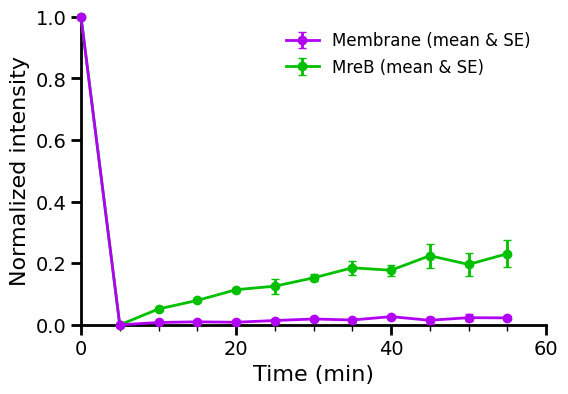

In [1]:
from __future__ import annotations

import csv
import math
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator


ERROR_MODE = "sem"  # "sem" for standard error, "std" for standard deviation
OUTPUT_SVG = Path("02_FigS4D_plot_output/FigS4D.svg")
OUTPUT_CSV = Path("02_FigS4D_plot_output/FigS4D.csv")


@dataclass(frozen=True)
class DatasetConfig:
    name: str
    csv_path: Path


DATASETS = [
    DatasetConfig(
        name="FigS4B",
        csv_path=Path("00_Fig2F:S4B:S4C_output/FigS4B_intensity_data.csv")
    ),
    DatasetConfig(
        name="FigS4C",
        csv_path=Path("00_Fig2F:S4B:S4C_output/FigS4C_intensity_data.csv")
    ),
    DatasetConfig(
        name="Fig2F",
        csv_path=Path("00_Fig2F:S4B:S4C_output/Fig2F_intensity_data.csv")
    ),
]

REQUIRED_COLUMNS = {
    "Time/min",
    "Membrane_Normalized_Intensity",
    "mreb_Normalized_Intensity",
}


def normalize_time_key(time_value: str) -> float:
    return round(float(time_value), 6)


def load_dataset(config: DatasetConfig) -> tuple[dict[float, float], dict[float, float]]:
    if not config.csv_path.exists():
        raise FileNotFoundError(f"Missing CSV: {config.csv_path}")

    per_time: dict[float, dict[str, list[float]]] = {}

    with config.csv_path.open(newline="") as f:
        reader = csv.DictReader(f)
        header = set(reader.fieldnames or [])
        missing = REQUIRED_COLUMNS - header
        if missing:
            missing_list = ", ".join(sorted(missing))
            raise ValueError(f"{config.name} missing columns: {missing_list}")

        for row in reader:
            if not row:
                continue
            time_raw = (row.get("Time/min") or "").strip()
            if not time_raw:
                continue
            time_key = normalize_time_key(time_raw)
            mem_val = float(row["Membrane_Normalized_Intensity"])
            mreb_val = float(row["mreb_Normalized_Intensity"])
            entry = per_time.setdefault(time_key, {"mem": [], "mreb": []})
            entry["mem"].append(mem_val)
            entry["mreb"].append(mreb_val)

    membrane_map = {}
    mreb_map = {}
    for time_value, values in per_time.items():
        mem_vals = values["mem"]
        mreb_vals = values["mreb"]
        membrane_map[time_value] = float(np.mean(mem_vals))
        mreb_map[time_value] = float(np.mean(mreb_vals))
        if len(mem_vals) > 1 or len(mreb_vals) > 1:
            print(f"Warning: {config.name} time {time_value} has {len(mem_vals)} rows; averaged.")

    return membrane_map, mreb_map


def mean_and_error(values: list[float], error_mode: str) -> tuple[float, float]:
    arr = np.array(values, dtype=float)
    mean_val = float(np.mean(arr))
    if len(arr) < 2:
        return mean_val, 0.0
    std = float(np.std(arr, ddof=1))
    if error_mode == "sem":
        return mean_val, std / math.sqrt(len(arr))
    return mean_val, std


def write_combined_csv(
    path: Path,
    times: list[float],
    membrane_mean: list[float],
    membrane_err: list[float],
    mreb_mean: list[float],
    mreb_err: list[float],
    counts: list[int],
) -> None:
    with path.open("w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(
            [
                "Time/min",
                "Membrane_Mean",
                f"Membrane_{ERROR_MODE.upper()}",
                "mreb_Mean",
                f"mreb_{ERROR_MODE.upper()}",
                "N",
            ]
        )
        for time_value, mem_mean, mem_err, mreb_mean_val, mreb_err_val, n in zip(
            times, membrane_mean, membrane_err, mreb_mean, mreb_err, counts
        ):
            writer.writerow([time_value, mem_mean, mem_err, mreb_mean_val, mreb_err_val, n])


def main() -> None:
    membrane_maps = []
    mreb_maps = []
    dataset_times = []

    for config in DATASETS:
        print(f"Loading {config.name}...")
        mem_map, mreb_map = load_dataset(config)
        membrane_maps.append(mem_map)
        mreb_maps.append(mreb_map)
        dataset_times.append(set(mem_map.keys()) & set(mreb_map.keys()))

    common_times = set.intersection(*dataset_times) if dataset_times else set()
    if not common_times:
        raise ValueError("No overlapping timepoints across datasets.")

    times = sorted(common_times)
    membrane_mean = []
    membrane_err = []
    mreb_mean = []
    mreb_err = []
    counts = []

    for time_value in times:
        mem_values = [mem_map[time_value] for mem_map in membrane_maps if time_value in mem_map]
        mreb_values = [mreb_map[time_value] for mreb_map in mreb_maps if time_value in mreb_map]
        counts.append(min(len(mem_values), len(mreb_values)))

        mem_mean, mem_err_val = mean_and_error(mem_values, ERROR_MODE)
        mreb_mean_val, mreb_err_val = mean_and_error(mreb_values, ERROR_MODE)

        membrane_mean.append(mem_mean)
        membrane_err.append(mem_err_val)
        mreb_mean.append(mreb_mean_val)
        mreb_err.append(mreb_err_val)

    write_combined_csv(OUTPUT_CSV, times, membrane_mean, membrane_err, mreb_mean, mreb_err, counts)

    fig, ax = plt.subplots(figsize=(6, 4))

    purple_color = "#B200F4"
    green_color = "#00C000"
    error_label = "SE" if ERROR_MODE == "sem" else "SD"

    ax.errorbar(
        times,
        membrane_mean,
        yerr=membrane_err,
        marker="o",
        markersize=6,
        color=purple_color,
        label=f"Membrane (mean & {error_label})",
        capsize=3,
        linewidth=2,
        zorder=10,
        clip_on=False,
    )

    ax.errorbar(
        times,
        mreb_mean,
        yerr=mreb_err,
        marker="o",
        markersize=6,
        color=green_color,
        label=f"MreB (mean & {error_label})",
        capsize=3,
        linewidth=2,
        zorder=5,
        clip_on=False,
    )

    ax.set_xlabel("Time (min)", fontsize=16)
    ax.set_ylabel("Normalized intensity", fontsize=16)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.tick_params(axis="x", which="major", length=7, width=2, labelsize=14)
    ax.tick_params(axis="x", which="minor", length=4, width=1)
    ax.tick_params(axis="y", which="major", length=7, width=2, labelsize=14)

    ax.set_ylim(0, 1)
    ax.set_yticks(
        ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
        labels=["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"],
    )
    ax.set_xlim(0, 60)

    ax.legend(loc="upper right", fontsize=12, frameon=False)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)

    plt.savefig(OUTPUT_SVG, format="svg", bbox_inches="tight", dpi=300)
    print(f"Saved combined plot to {OUTPUT_SVG}")


if __name__ == "__main__":
    main()
